In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from pathlib import Path
from yaml.loader import SafeLoader


sns.set_style("darkgrid")


dir_path = Path("outputs/2023-02-15/13-17-13")

# Recover the config used in the trading strategy.
cfg_path = dir_path.joinpath(".hydra/config.yaml")
with open(cfg_path) as f:
    cfg = yaml.load(f, Loader=SafeLoader)

# Output of the trading strategy.
output_data_path = dir_path.joinpath("plot_data.csv")
df = pd.read_csv(output_data_path)
df.drop(columns=["Unnamed: 0"], inplace=True)

if cfg["data"]["interval"] == "1d":
    df["datetime"] = pd.to_datetime(df["datetime_bt"]).dt.date
    df.drop(columns=["datetime_bt"], inplace=True)
    
elif cfg["data"]["interval"] == "1h":
    # Input to the trading strategy - used to recover the date.
    input_data_path = dir_path.joinpath("data")
    input_df0 = pd.read_csv(input_data_path.joinpath("df0.csv"))
    input_df1 = pd.read_csv(input_data_path.joinpath("df1.csv"))
    input_df = pd.merge(input_df0, input_df1, how="left", left_on=["datetime"], right_on=["datetime"])

    input_df["date"] = pd.to_datetime(input_df["datetime"]).dt.date
    df["date"] = pd.to_datetime(df["datetime_bt"]).dt.date
    
    assert len(df) == len(input_df), "Match lengths before datetime merge."

    # TODO: replace with a merge on date and some global_step which was fed to the backtest and used like: self.global_step = self.step[-1]..
    df["datetime"] = input_df["datetime"]
    df["date"] = pd.to_datetime(input_df["datetime"]).dt.date
    
# Forward fill theta for entries between retraining periods.
df["theta"].fillna(method="ffill", inplace=True)
df["mu"].fillna(method="ffill", inplace=True)

# Drop rows where every column in the subset has a NaN.
cols = df.columns[~df.columns.isin(["datetime", "datetime", "date"])]
df.dropna(axis=0, how="all", subset=cols, inplace=True)

date_index = False
# date_index = True

if date_index:
    # Rename the original index to `global_step`, then make `datetime` the new index, while keeping `global_step` as a column.
    df.index.rename("global_step", inplace=True)
    df = df.reset_index().set_index("datetime", drop=True)

df.tail(2)

,S0,S1,spread,spread_zscore,enter_long,enter_short,exit_long,exit_short,is_long,is_short,...,pf_value,NAV,cash,spread_mean,spread_std,A,B,alpha,beta,datetime
1541,80.139999,2.5311,0.197233,-0.596876,NaN,NaN,NaN,NaN,False,False,...,5.103977e+06,5.103977e+06,5.103977e+06,0.224935,0.046411,1.0,0.71,0.010833,0.265074,2023-02-13
1542,79.059998,2.4885,0.196826,-0.599547,NaN,NaN,NaN,NaN,False,False,...,5.103977e+06,5.103977e+06,5.103977e+06,0.224506,0.046169,1.0,0.71,0.010833,0.265074,2023-02-14


In [9]:
# df["stop_long"].describe()
# df["stop_short"].describe()

In [17]:
# df["roll_0"]
# df.query("roll_0")

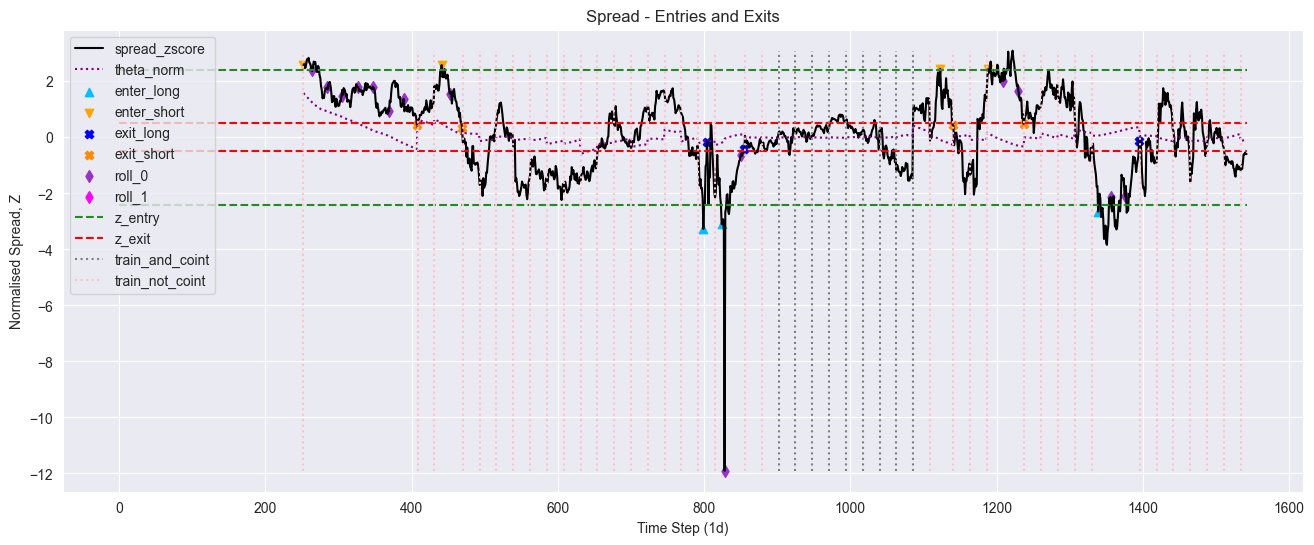

In [28]:
# Record when training occurred.
train_periods = df[df["train"]== 1]["train"].index.tolist()
# Record where training occurred and was/not cointegrated.
coint = df[df["cointegrated"]==True]["cointegrated"].index.tolist()
not_coint = df[df["cointegrated"]==False]["cointegrated"].index.tolist()

# Unpack config.
interval = cfg["data"]["interval"]
z_entry = cfg["pairs"]["z_entry"]
z_exit = cfg["pairs"]["z_exit"]

# Visualise.
df["theta_norm"] = (df["theta"] - df["spread_mean"]) / df["spread_std"]

# Plot portfolio z-score and trade signals.
fig = plt.figure()
fig.set_size_inches(16, 6)

plt.plot(df["spread_zscore"], color="black", label="spread_zscore")
plt.plot(df["theta_norm"], color="purple", label="theta_norm", linestyle="dotted")
plt.scatter(df.index, df["enter_long"], color="deepskyblue", marker="^", label="enter_long")
plt.scatter(df.index, df["enter_short"], color="orange", marker="v", label="enter_short")
plt.scatter(df.index, df["exit_long"], color="blue", marker="X", label="exit_long")
plt.scatter(df.index, df["exit_short"], color="darkorange", marker="X", label="exit_short")

# Plot where postion rolls occurred.
plt.scatter(df.query("roll_0").index, df.query("roll_0")["spread_zscore"], color="darkorchid", marker="d", label="roll_0")
plt.scatter(df.query("roll_1").index, df.query("roll_1")["spread_zscore"], color="magenta", marker="d", label="roll_1")
xmin = df.index[0]
xmax = df.index[-1]

# Trade entry and exit thresholds.
plt.hlines([-z_entry, z_entry], xmin=xmin, xmax=xmax, color="forestgreen", linestyle="dashed", label="z_entry")
plt.hlines([-z_exit, z_exit], xmin=xmin, xmax=xmax, color="red", linestyle="dashed", label="z_exit")

plot_train_times_coint = True
if plot_train_times_coint:
    # Record when training occurred while cointegrated.
    plt.vlines(coint, ymin=np.min(df["spread_zscore"]), ymax=np.max(df["spread_zscore"]), color="grey", linestyle="dotted", label="train_and_coint")

plot_train_times_not_coint = True
if plot_train_times_not_coint:
    # Record when training occurred while not cointegrated.
    plt.vlines(not_coint, ymin=np.min(df["spread_zscore"]), ymax=np.max(df["spread_zscore"]), color="pink", linestyle="dotted", label="train_not_coint")

if date_index:
    ax = fig.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%b"))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.xticks(rotation=75, horizontalalignment="right")
    
plt.title("Spread - Entries and Exits")
plt.xlabel(f"Time Step ({interval})")
plt.ylabel("Normalised Spread, Z")
plt.legend()
plt.show()

In [ ]:
df["exit_long"].describe()

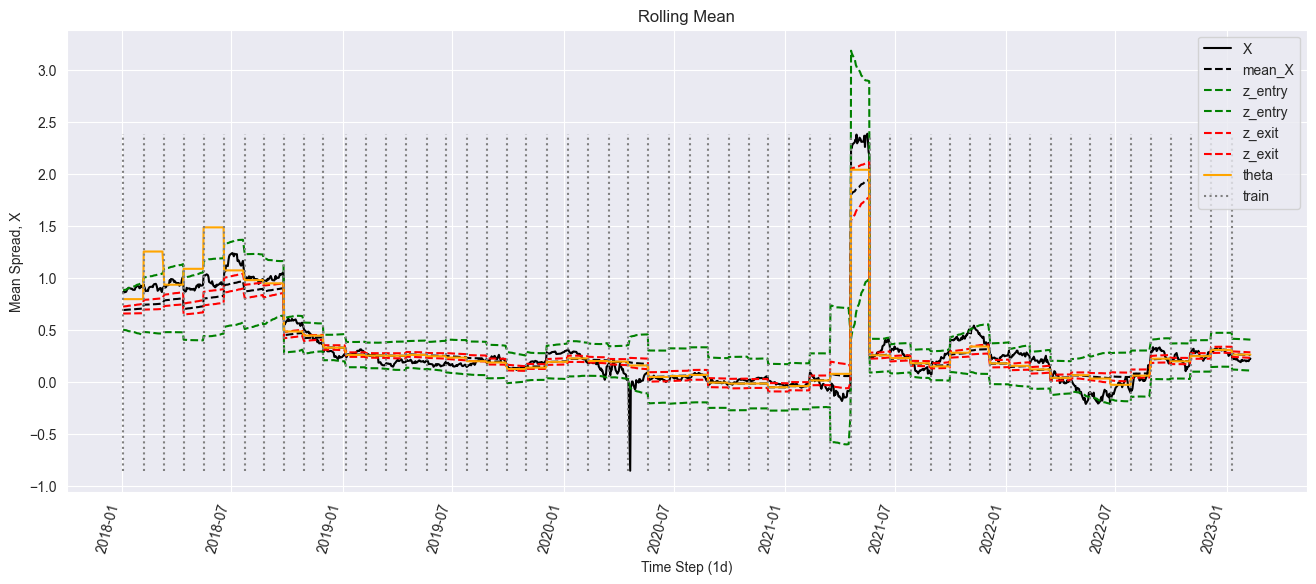

In [15]:
# Plot portfolio spread vs. long run means.
fig = plt.figure()
fig.set_size_inches(16, 6)
plt.plot(df["spread"], color="black", label="X")
plt.plot(df["spread_mean"], color="black", linestyle="dashed", label="mean_X")
plt.plot(df["spread_mean"] + z_entry*df["spread_std"], color="green", linestyle="dashed", label="z_entry")
plt.plot(df["spread_mean"] - z_entry*df["spread_std"], color="green", linestyle="dashed", label="z_entry")
plt.plot(df["spread_mean"] + z_exit*df["spread_std"], color="red", linestyle="dashed", label="z_exit")
plt.plot(df["spread_mean"] - z_exit*df["spread_std"], color="red", linestyle="dashed", label="z_exit")

# OU Long-Run Mean
plt.plot(df["theta"], color="orange", label="theta")

# OU Mean Reversion Speed
# plt.plot(df["mu"], color="blue", label="mu")

# Record when training occurred.
plt.vlines(train_periods, ymin=np.min(df["spread"]), ymax=np.max(df["spread"]), color="grey", linestyle="dotted", label="train")

if date_index:
    # Setting the axis locators speeds up index plotting.
    ax = fig.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.grid(True)
    plt.xticks(rotation=75, horizontalalignment="right")

plt.title("Rolling Mean")
plt.xlabel(f"Time Step ({interval})")
plt.ylabel("Mean Spread, X")
plt.legend()
plt.show()


plot_volatility = False
if plot_volatility:
    plt.plot(df["spread_std"], color="green", label="spread_zscore")
    plt.title("Rolling Volatility")
    plt.xlabel(f"Time Step ({interval})")
    plt.ylabel("Std Dev of Spread, X")
    plt.legend()
    plt.show()

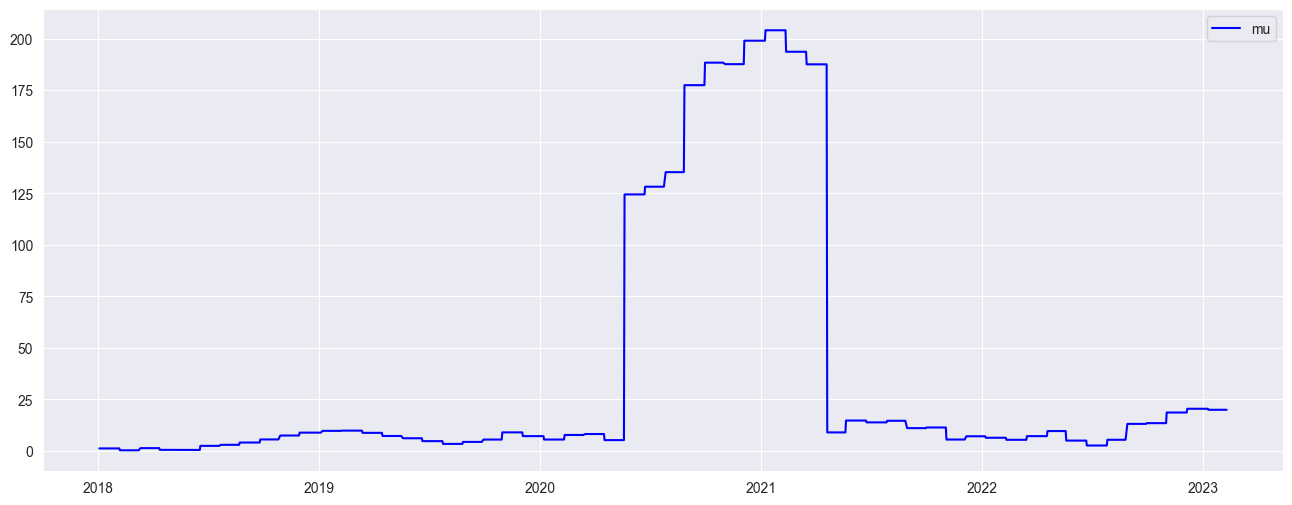

In [4]:
# Plot portfolio spread vs. long run means.
fig = plt.figure()
fig.set_size_inches(16, 6)
# plt.plot(df["spread"], color="black", label="X")

# OU Long-Run Mean
# plt.plot(df["theta"], color="orange", label="theta")

# OU Mean Reversion Speed
plt.plot(df["mu"], color="blue", label="mu")
plt.legend()
plt.show()

# Portfolio Returns

In [5]:
# Portfolio value at time t. Note size is negative for shorts.
df["value"] = (df["S0_price"] * df["S0_size"]) + (df["S1_price"] * df["S1_size"]) + df["cash"]

# TODO: check this.
# multiplier0 = cfg["pairs"]["multiplier0"]
# multiplier1 = cfg["pairs"]["multiplier1"]
# df["value"] = multiplier0 * (df["S0_price"] * df["S0_size"]) + multiplier1 * (df["S1_price"] * df["S1_size"]) + df["cash"]

# Simple returns
df["return"] = df["value"].pct_change()
# df["cumulative_return"] = df["return"].cumsum()
df["cumulative_return"] = (1.0 + df["return"]).cumprod()

risk_free_return = 0.0
# total_return = df["cumulative_return"].iloc[-1]
# sharpe_ratio = (total_return - risk_free_return) / df["return"].std()
expected_return = df["return"].mean()
sharpe_ratio = (expected_return - risk_free_return) / df["return"].std()

# TODO: better to use log returns before annualising.
sharpe_ratio_annualised_1 = sharpe_ratio * np.sqrt(23*252)
sharpe_ratio_annualised_2 = sharpe_ratio * np.sqrt(252)  # Argument: hourly data is for entry, time is daily.

print(sharpe_ratio)
# print(sharpe_ratio_annualised_1)
print(sharpe_ratio_annualised_2)

0.007344733066302603
0.11659402283753738


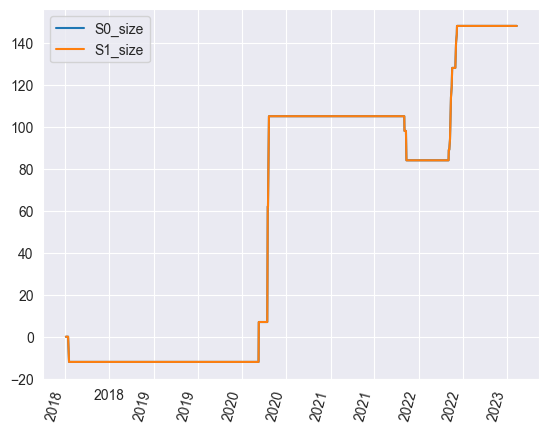

In [6]:
fig = plt.figure()
if date_index:
    # Setting the axis locators speeds up index plotting.
    ax = fig.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.grid(True)
    plt.xticks(rotation=75, horizontalalignment="right")

plt.plot(df["S0_size"], label="S0_size")
plt.plot(df["S1_size"], label="S1_size")
plt.legend()
plt.show()

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_2118/48408762.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


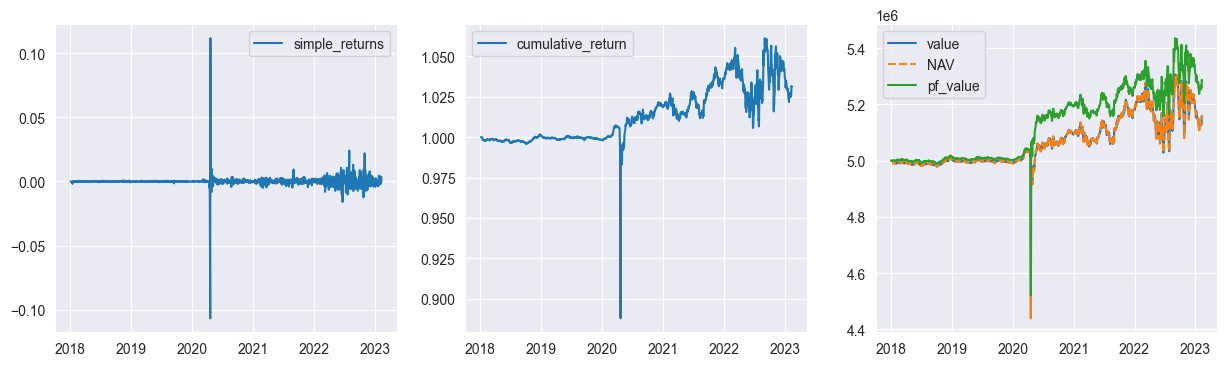

In [7]:
fig = plt.figure()
fig.set_size_inches(15, 4)

if date_index:
    # Setting the axis locators speeds up index plotting.
    ax = fig.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.grid(True)
    plt.xticks(rotation=75, horizontalalignment="right")

# Simple Returns.
plt.subplot(1, 3, 1)
plt.plot(df["return"], label="simple_returns")
plt.legend()

# Cumulative Returns.
plt.subplot(1, 3, 2)
plt.plot(df["cumulative_return"], label="cumulative_return")
plt.legend()

# Portfolio values.
plt.subplot(1, 3, 3)
plt.plot(df["value"], label="value")
plt.plot(df["NAV"], label="NAV", linestyle="dashed")
plt.plot(df["pf_value"], label="pf_value")
plt.legend()

plt.show()

In [8]:
df["cumulative_return"].iloc[-1]

1.031247625599997

In [9]:
colname = "value"
log_returns = np.log(df[colname]/df[colname].shift())
log_returns.fillna(0.0, inplace=True)
log_returns.replace([np.inf, -np.inf], 0.0, inplace=True)
log_returns.mean(), log_returns.std()

(2.3889251720200444e-05, 0.004869455312867845)

In [10]:
def sharpe_ratio_log(df, colname, risk_free_return=0.0):
    # Log returns are additive - better choice when doing *sqrt(252)
    log_returns = np.log(df[colname]/df[colname].shift())
    log_returns.fillna(0.0, inplace=True)
    log_returns.replace([np.inf, -np.inf], 0.0, inplace=True)

    sharpe = (log_returns.mean() - risk_free_return) / log_returns.std()
    return sharpe


df["value"] = df["value"].astype(float)
sr_log = sharpe_ratio_log(df, colname="value")

# Annualise: data is hourly. Futures: 23 hours in a trading day, 252 trading days in a year.
# Portfolio returns are a BM -> volatility scales with sqrt(time).
# sharpe_ratio_annual_1 = sr_log*np.sqrt(23*252)

# Hourly as entry?
sharpe_ratio_annual_2 = sr_log*np.sqrt(252)

print(sr_log)
# print(sharpe_ratio_annual_1)
print(sharpe_ratio_annual_2)

0.0049059392037281
0.07787937048160078


In [11]:
# fig = plt.figure()
# # fig.set_size_inches(10, 8)

# plt.plot(df["A"], color="blue", label="A")
# plt.plot(df["B"], color="orange", label="B")

# # Setting the axis locators speeds up index plotting.
# ax = fig.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# ax.grid(True)
# plt.xticks(rotation=75, horizontalalignment="right")

# plt.legend()
# plt.show()



# fig = plt.figure()

# plt.plot(df["alpha"], color="blue", label="alpha")
# plt.plot(df["beta"], color="orange", label="beta")

# # Setting the axis locators speeds up index plotting.
# ax = fig.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# ax.grid(True)
# plt.xticks(rotation=75, horizontalalignment="right")

# plt.legend()
# plt.show()

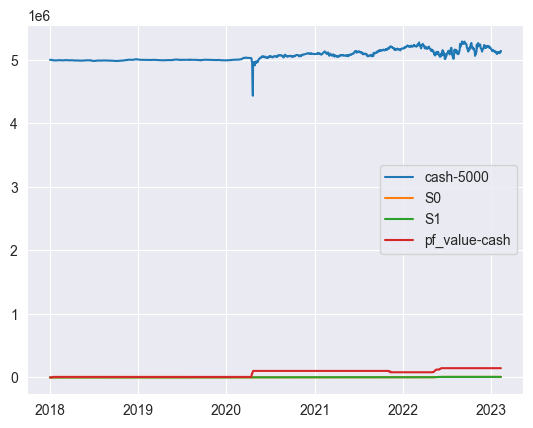

In [12]:
plt.plot(df["cash"]-5000, label="cash-5000")
# plt.plot(df["cash"], label="cash")
plt.plot(df["S0_price"]*df["S0_size"], label="S0")
plt.plot(df["S1_price"]*df["S1_size"], label="S1")
# plt.plot(-12.5*df["S1_price"]*df["S1_size"], label="S1*mul")
plt.plot(df["pf_value"] - df["cash"], label="pf_value-cash")
plt.legend()

# plot s0 s1 purchases - tally with cash?